# Hands on : introduction to NN on HEP dataset

This tutorial will be focused on the classification problem in a physics example: training a neural network classifier to distinguish the Higgs boson signals from background events.

In this tutorial, we will use TensorFlow and Keras to train our neural networks (different from the first hands on tutorial which uses PyTorch), but the concept is the same, and we will be focused more on data processing, model optimization and overtraining.

Outline:
- Load data from root files
- Explore the data and weights
- Preprocess data for training
- Train a neural network
- Quantify its performance
- Tune the model and overtraining

## Intall and import Packages

In [1]:
!pip install uproot

In [2]:
import numpy as np  # numpy is a python package for data processing
import pandas as pd  # pandas is a python package for data processing
import matplotlib.pyplot as plt  # matplotlib is a powerful package for plotting results
import uproot  # uproot is a useful python package to read data from root files

import tensorflow as tf
from keras.metrics import AUC

print("Tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

pd.set_option('display.max_columns', None)  # to see all columns of df.head()

2024-08-05 16:35:52.202885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 16:35:54.181458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow version: 2.16.1
Num GPUs Available:  0


2024-08-05 16:35:56.461738: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Load events

Data were created from ATLAS Open Data:

http://opendata.atlas.cern/release/2020/documentation/datasets/intro.html

The dataset we will be using contains MC simulation of the Standard Model Higgs boson production events (signal), as well as Standard Model background, including top-quark-pair production, single-top production, production of weak bosons in association with jets (W+jets, Z+jets) and production of a pair of bosons (diboson WW, WZ, ZZ).

All the data are stored in a root file, which contains different kinematic variables of each event, the event label (`label`) to indicate whether an event is a signal or background, as well as the MC event weights (`mcWeight`). We use [uproot](https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf) to read data from the root file.

In [3]:
filename = "dataWW_d1.root"
file = uproot.open(filename)

# show what is inside the root file loaded from uproot
print(file.classnames())

tree = file["tree_event"]  # select the TTree inside the root file
tree.show()  # show all the branches inside the TTree
dfall = tree.arrays(library="pd")  # convert uproot TTree into pandas dataframe
print("============================================")
print("File loaded with ", len(dfall), " events ")

{'tree_event;1': 'TTree'}
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
index                | int64_t                  | AsDtype('>i8')
eventNumber          | int64_t                  | AsDtype('>i8')
label                | int64_t                  | AsDtype('>i8')
met_et               | double                   | AsDtype('>f8')
met_phi              | double                   | AsDtype('>f8')
lep_n                | int64_t                  | AsDtype('>i8')
lep_pt_0             | double                   | AsDtype('>f8')
lep_pt_1             | double                   | AsDtype('>f8')
lep_eta_0            | double                   | AsDtype('>f8')
lep_eta_1            | double                   | AsDtype('>f8')
lep_phi_0            | double                   | AsDtype('>f8')
lep_phi_1            | double                   | AsDtype('>f8')
lep_E_0              | double   

In [4]:
# dump list of feature
dfall.columns

Index(['index', 'eventNumber', 'label', 'met_et', 'met_phi', 'lep_n',
       'lep_pt_0', 'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0',
       'lep_phi_1', 'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1',
       'lep_type_0', 'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1',
       'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1', 'jet_E_0',
       'jet_E_1', 'mcWeight', 'runNumber', 'channelNumber'],
      dtype='object')

In [5]:
# examine first few events
dfall.head()

,index,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
0,0,249632,1,25.118,1.14010,2,46.439,44.589,0.131030,0.40654,2.34760,-2.41510,46838.0,48325.0,1,-1,13,11,1,53.680,-7.000,2.4346,-7.00000,-0.76667,-7.00000,308720.0,-7.0,0.000002,284500,345323
1,1,892975,1,27.974,0.84442,2,86.819,55.438,-0.017265,-0.16338,-1.44520,-1.72950,86832.0,56179.0,1,-1,11,13,1,126.700,-7.000,-1.2789,-7.00000,1.66290,-7.00000,245670.0,-7.0,0.000002,284500,345323
2,2,730573,0,123.290,-2.94810,2,105.810,40.506,-1.338900,-1.03500,0.68539,-0.90527,215700.0,64211.0,1,-1,13,13,0,-7.000,-7.000,-7.0000,-7.00000,-7.00000,-7.00000,-7.0,-7.0,0.002468,284500,363492
3,3,717584,0,78.558,1.04450,2,56.666,35.124,2.294600,1.88700,2.13110,-2.83820,283930.0,118570.0,-1,1,11,11,2,79.799,53.942,1.6270,0.55314,-1.84880,-0.47055,211610.0,63629.0,0.000197,284500,363492
4,4,319020,0,15.863,0.74840,2,94.708,72.811,0.812740,0.77954,1.84940,0.45967,127750.0,96077.0,-1,1,11,11,1,143.180,-7.000,-0.6358,-7.00000,-1.91230,-7.00000,173810.0,-7.0,0.000197,284500,363492


## Event Selection

In this example, we want to focus on events with exactly 2 leptons. Therefore, we will select only events with exactly two leptons:

`dfall.lep_n == 2`

In addition, we only keep events with positive event weight (the column `mcWeight`) to make it simple. This is in principle wrong, but many Data Science tools break given a negative weight.

In [6]:
print("Number of events before selections:", len(dfall))
fulldata = dfall[
    (dfall.lep_n == 2) & (dfall.mcWeight > 0)
]  # only keep events with exactly two leptons and positive event weights
print("Number of events after selections:", len(fulldata))

Number of events before selections: 600000
Number of events after selections: 577357


The column `label` is whether an event is a signal (Higgs boson events) or a background. An event with the `label == 1` means it is a signal event, otherwise (`label == 0`) it is a background event.

The event weights (`mcWeight`) will be used during the training. The event with a larger weight will have a larger contribution in the loss function.

In [7]:
target = fulldata.label
weights = fulldata.mcWeight

print("Number of selected signal events:", len(fulldata[target == 1]))
print("Number of selected background events:", len(fulldata[target == 0]))

Number of selected signal events: 396976
Number of selected background events: 180381


### For simplicity, we'll only use some features on the first pass

In [8]:
data = pd.DataFrame(fulldata, columns=["met_et", "met_phi", "lep_pt_0", "lep_pt_1", 'lep_phi_0', 'lep_phi_1'])

# Or we can use more features to improve the discrimination power:
# data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_eta_0', 'lep_eta_1',
#                                      'lep_phi_0', 'lep_phi_1','jet_n','jet_pt_0',
#                                      'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1'])

# We can also engineer our own feature:
# data["lep_deltaphi"]=np.abs(np.mod(data.lep_phi_1-data.lep_phi_0+3*np.pi,2*np.pi)-np.pi)

data.head()

,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
0,25.118,1.14010,46.439,44.589,2.34760,-2.41510
1,27.974,0.84442,86.819,55.438,-1.44520,-1.72950
2,123.290,-2.94810,105.810,40.506,0.68539,-0.90527
3,78.558,1.04450,56.666,35.124,2.13110,-2.83820
4,15.863,0.74840,94.708,72.811,1.84940,0.45967


<Figure size 640x480 with 0 Axes>

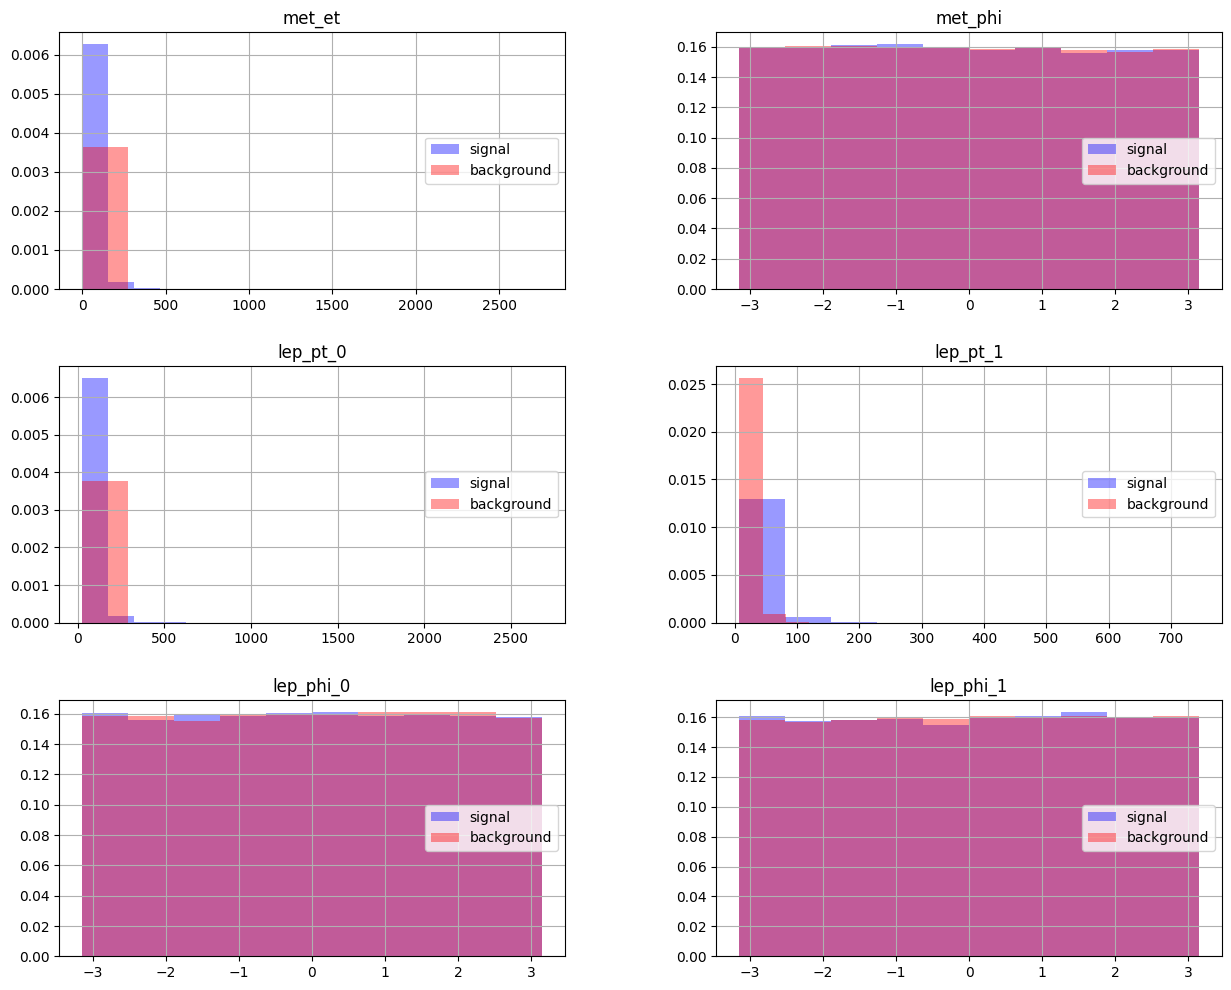

In [9]:
plt.figure()
ax = data[target == 0].hist(
    weights=weights[target == 0], figsize=(15, 12), color='b', alpha=0.4, density=True, label="signal"
)
ax = ax.flatten()[: data.shape[1]]  # to avoid error if holes in the grid of plots (like if 7 or 8 features)
data[target == 1].hist(
    weights=weights[target == 1], figsize=(15, 12), color='r', alpha=0.4, density=True, ax=ax, label="background"
)
for i in range(len(ax)):
    ax[i].legend(loc='right')
plt.show()

## Data splitting

It is very common in machine learning to split data into multiple independent sets, and only use part of the data for training/optimizing the machine learning models, and the rest for testing/evaluating performance.

In the following, we will split the whole data into 50% training set, 25% validation set and 25% test set:

- __Training Dataset:__ The sample of data used to fit the model.
- __Validation Dataset:__ The sample used to provide an unbiased evaluation of a model fit on the training dataset while tuning  hyperparameters.
- __Test Dataset:__ The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.


The API referecne of the `train_test_split` function:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

### Split the Data into training set and rest (validation + test)

In [10]:
from sklearn.model_selection import train_test_split

(
    X_train,
    X_val_and_test,
    y_train,
    y_val_and_test,
    weights_train,
    weights_val_and_test
) = train_test_split(data, target, weights, train_size=0.5)

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("Training Weights shape: ", weights_train.shape, "\n")
print("X_val_and_test Shape: ", X_val_and_test.shape)
print("y_val_and_test Shape: ", y_val_and_test.shape)
print("weights_val_and_test shape: ", weights_val_and_test.shape)

X_train Shape:  (288678, 6)
y_train Shape:  (288678,)
Training Weights shape:  (288678,) 

X_val_and_test Shape:  (288679, 6)
y_val_and_test Shape:  (288679,)
weights_val_and_test shape:  (288679,)


### Split the rest (val + test) into validation set and test set

In [11]:
(
    X_test,
    X_val,
    y_test,
    y_val,
    weights_test,
    weights_val,
) = train_test_split(X_val_and_test, y_val_and_test, weights_val_and_test, train_size=0.5)

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("weights_train shape: ", weights_train.shape, "\n")
print("X_val Shape: ", X_val.shape)
print("y_val Shape: ", y_val.shape)
print("weights_val shape: ", weights_val.shape, "\n")
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)
print("weights_test shape: ", weights_test.shape)

X_train Shape:  (288678, 6)
y_train Shape:  (288678,)
weights_train shape:  (288678,) 

X_val Shape:  (144340, 6)
y_val Shape:  (144340,)
weights_val shape:  (144340,) 

X_test Shape:  (144339, 6)
y_test Shape:  (144339,)
weights_test shape:  (144339,)


## Standardize the Data

When optimizing the node weights of a neural netowrk, the input scale can significantly affect the performance. That is, unscaled (raw) input variables can result in a slow or unstable learning process. We would therefore like to rescale input variables prior to training a neural network model.

There are 2 common ways to rescale the data:

1. **Scale to Mean of 0 and Variance of 1.0:**   $\ \ \ \ x^\prime = (x-\mu)/\sigma$
2. **Scale to Max of 1 and Min of 0:**   $\ \ \ \ x^\prime = (x-x_{\mathrm{min}})/(x_{\mathrm{max}}-x_{\mathrm{min}})$

In the following, we will go with the first approach, but feel free to try the second approach! (hint: use [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html))

In [12]:
from sklearn.preprocessing import StandardScaler

print("Before standardization:")
print("X_train mean:", X_train.to_numpy().mean(axis=0).round(2), "std:",  X_train.to_numpy().std(axis=0).round(2))
print("X_val mean:", X_val.to_numpy().mean(axis=0).round(2), "std:",  X_val.to_numpy().std(axis=0).round(2))
print("X_test mean:", X_test.to_numpy().mean(axis=0).round(2), "std:",  X_test.to_numpy().std(axis=0).round(2), "\n")

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("After standardization:")
print("X_train mean, std: ", X_train.mean(axis=0).round(2), X_train.std(axis=0).round(2))
print("X_val mean, std: ", X_val.mean(axis=0).round(2), X_val.std(axis=0).round(2))
print("X_test mean, std: ", X_test.mean(axis=0).round(2), X_test.std(axis=0).round(2))

Before standardization:
X_train mean: [ 6.056e+01 -1.000e-02  6.013e+01  2.788e+01  1.000e-02  1.000e-02] std: [47.07  1.81 41.42 20.24  1.81  1.81]
X_val mean: [ 6.037e+01 -1.000e-02  6.001e+01  2.779e+01  0.000e+00  1.000e-02] std: [46.25  1.81 40.76 19.74  1.81  1.82]
X_test mean: [ 6.044e+01 -0.000e+00  5.994e+01  2.787e+01  0.000e+00  1.000e-02] std: [47.    1.81 40.16 20.19  1.81  1.81] 

After standardization:
X_train mean, std:  [-0. -0. -0.  0.  0. -0.] [1. 1. 1. 1. 1. 1.]
X_val mean, std:  [-0. -0. -0. -0. -0. -0.] [0.98 1.   0.98 0.98 1.   1.  ]
X_test mean, std:  [-0.  0. -0. -0. -0.  0.] [1.   1.   0.97 1.   1.   1.  ]


## Adjust the Signal/Background Weights for balanced training
Naturally, we would like to have an equal emphasis on the signal and background during the training. To do so, we can "normalize" the signal weights, and background weights such that the sum of weights is the same between signal and background. Note that the adjustment is only needed for train and validation sets, as we do not use test set to calculate the loss function.

In [13]:
print("Sum of training signal weights before normalization:", weights_train[y_train == 1].sum())
print("Sum of training background weights before normalization:", weights_train[y_train == 0].sum())
print("Sum of validation signal weights before normalization:", weights_val[y_val == 1].sum())
print("Sum of validation background weights before normalization:", weights_val[y_val == 0].sum(), "\n")

weights_train[y_train == 0] *= len(weights_train) / weights_train[y_train == 0].sum()
weights_train[y_train == 1] *= len(weights_train) / weights_train[y_train == 1].sum()

weights_val[y_val == 0] *= len(weights_val) / weights_val[y_val == 0].sum()
weights_val[y_val == 1] *= len(weights_val) / weights_val[y_val == 1].sum()

print("Sum of training signal weights after normalization:", weights_train[y_train == 1].sum())
print("Sum of training background weights after normalization:", weights_train[y_train == 0].sum())
print("Sum of validation signal weights after normalization:", weights_val[y_val == 1].sum())
print("Sum of validation background weights after normalization:", weights_val[y_val == 0].sum())

Sum of training signal weights before normalization: 3.0887525208000004
Sum of training background weights before normalization: 80.09210999409999
Sum of validation signal weights before normalization: 1.5386304504000003
Sum of validation background weights before normalization: 39.7890679365 

Sum of training signal weights after normalization: 288678.0
Sum of training background weights after normalization: 288678.00000000006
Sum of validation signal weights after normalization: 144339.99999999994
Sum of validation background weights after normalization: 144340.00000000003


## Training the neural network

In the following, we will use TensorFlow and Keras to build our neural network and train the model.

The architecture is pretty simple: A fully-connected network with 2 hidden layers with the ReLu activation function.
The last layer uses the Sigmoid activation to output a classifier score that ranges from 0 to 1.

In [14]:
model = tf.keras.models.Sequential(
    [
        tf.keras.Input((X_train.shape[1],)), # input layer
        tf.keras.layers.Dense(128, activation='relu'),  # layer 1
        tf.keras.layers.Dense(128, activation='relu'),  # layer 2
        tf.keras.layers.Dense(1, activation='sigmoid')  # Last layer
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,537 (68.50 KB)

 Trainable params: 17,537 (68.50 KB)

 Non-trainable params: 0 (0.00 B)

We will use the binary cross-entropy as the loss function, and use the Adam optimizer to train the model.

In [15]:
model.compile(
    loss="binary_crossentropy",  # use loss="mean_squared_error" for MSE loss
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # tf.keras.optimizers.experimental.SGD for the SGD optimizer
    weighted_metrics=[AUC(name="auc")],  # monitor AUC for each epoch during the training
)

In the following, we train the model with 10 epochs with a batch size of 128.

In [16]:
print("Start training!")

# model.fit() performs the training

the_fit = model.fit(
    X_train,
    y_train.values,
    sample_weight=weights_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, y_val, weights_val),
    # callbacks=[K.callbacks.EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')], # uncomment to use early stopping (should also increase the epochs)
)

Start training!
Epoch 1/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - auc: 0.8326 - loss: 0.9782 - val_auc: 0.8617 - val_loss: 0.8830
Epoch 2/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - auc: 0.8611 - loss: 0.8821 - val_auc: 0.8680 - val_loss: 0.8635
Epoch 3/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.8673 - loss: 0.8615 - val_auc: 0.8690 - val_loss: 0.8561
Epoch 4/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - auc: 0.8698 - loss: 0.8526 - val_auc: 0.8685 - val_loss: 0.8590
Epoch 5/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.8685 - loss: 0.8545 - val_auc: 0.8693 - val_loss: 0.8547
Epoch 6/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.8695 - loss: 0.8505 - val_auc: 0.8697 - val_loss: 0.8549
Epoch 7/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.8689 - loss: 0.8586 - val_auc: 0.8698 - val_loss: 0.8524
Epoch 8/10
2256/2256 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc: 0.8713 - loss: 0.8524 - val_auc: 0.8710 - val_loss: 0.8480
Epoch 9/10
2256/2256 ━━━

### Plot the training progress

Below, we plot the training loss, validation loss, training AUC and validation AUC per epoch.

Ideally, we should see the loss going down, and AUC going up with the number of epochs trained.

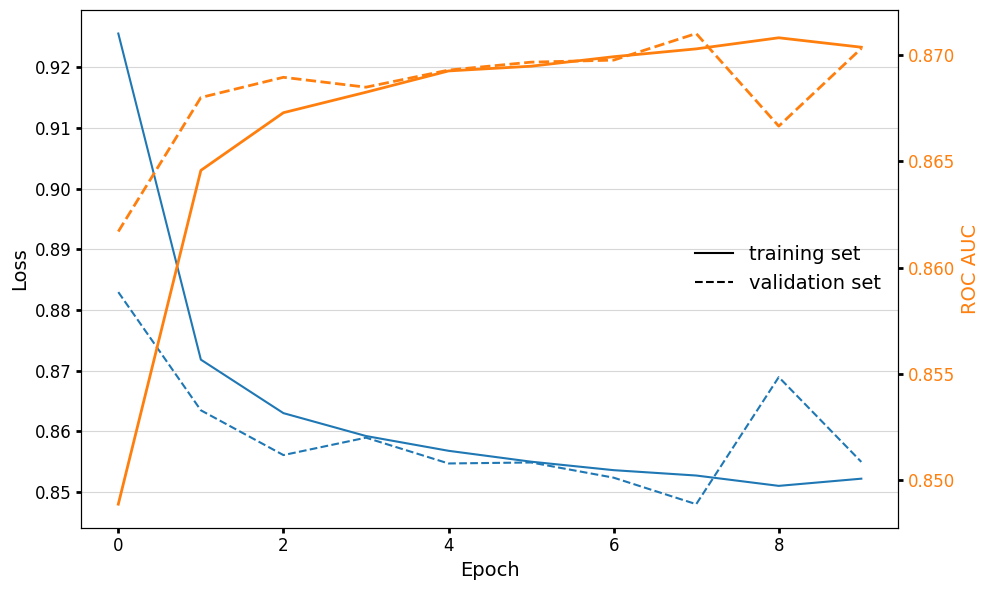

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(the_fit.history['loss'], color="tab:blue")
ax.plot(the_fit.history['val_loss'], color="tab:blue", ls="--")
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=12)
ax.grid(True, axis='y')

ax2 = ax.twinx()
ax2.set_ylabel("ROC AUC", color='tab:orange', fontsize=14)
ax2.tick_params(width=2, grid_alpha=0.5, labelsize=12, axis='y', labelcolor='tab:orange')
ax2.plot(the_fit.history['auc'], color='tab:orange', lw=2)
ax2.plot(the_fit.history['val_auc'], color='tab:orange', ls='--', lw=2)
# ax2.set_ylim([0, 1])

ax2.plot([], [], color="black", label="training set")
ax2.plot([], [], color="black", ls='--', label="validation set")
ax2.legend(fontsize=14, frameon=False, loc="right")
fig.tight_layout()

### Use the model to make predicions!
Evaluate the model based on predictions made with X_test $\rightarrow$ y_test

In [18]:
y_pred_test = model.predict(X_test).flatten()
y_pred_train = model.predict(X_train).flatten()

print("y_pred_test: ", y_pred_test)
print("y_pred_train: ", y_pred_train)

4511/4511 ━━━━━━━━━━━━━━━━━━━━ 3s 673us/step
9022/9022 ━━━━━━━━━━━━━━━━━━━━ 6s 657us/step
y_pred_test:  [0.72072357 0.84119636 0.88146865 ... 0.895865   0.87717    0.8804864 ]
y_pred_train:  [0.05062103 0.40197337 0.75261706 ... 0.89510846 0.5064645  0.00109564]


### ROC curves and Area Under the Curve (AUC)

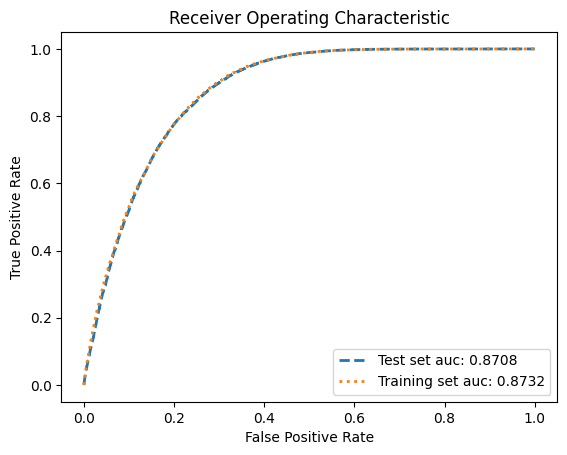

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=y_pred_test, sample_weight=weights_test)
fpr_train, tpr_train, _ = roc_curve(y_true=y_train, y_score=y_pred_train, sample_weight=weights_train)
auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_test, sample_weight=weights_test)
auc_train = roc_auc_score(y_true=y_train.values, y_score=y_pred_train, sample_weight=weights_train)
plt.plot(fpr_test, tpr_test, color='tab:blue', lw=2, ls="--", label=f"Test set auc: {auc_test:.4f}")
plt.plot(fpr_train, tpr_train, color='tab:orange', lw=2, ls=":", label=f"Training set auc: {auc_train:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Plotting NN Score for Signal and Background

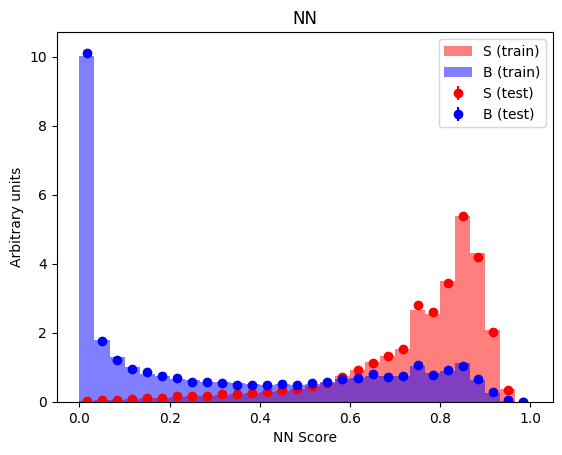

In [20]:
from extra_functions import compare_train_test

compare_train_test(
    y_pred_train,
    y_train,
    y_pred_test,
    y_test,
    xlabel="NN Score",
    title="NN",
    weights_train=weights_train.values,
    weights_test=weights_test.values,
)

## Significance Function

In a standard statistical analysis for a search, an observed significance is obtained. This corresponds to the significance with which we reject the background-only hypothesis. That is, the higher the significance, the more likely the signal we are searching for exists.

We can use the formula below to obtain an estimated value of the expected significance.

$Z = \sqrt{2+((s+b)\ln(1+s/b)-s)}$

**see [arXiv:1007.1727](https://arxiv.org/pdf/1007.1727.pdf) [Eq. 97]**

This corresponds to the signal sensitivity. This is a good indication of the performance of our classification model. => We want the significance to be as high as possible.



In [21]:
from math import sqrt
from math import log


def amsasimov(s, b):
    if b <= 0 or s <= 0:
        return 0
    try:
        return sqrt(2 * ((s + b) * log(1 + float(s) / b) - s))
    except ValueError:
        print(1 + float(s) / b)
        print(2 * ((s + b) * log(1 + float(s) / b) - s))

The simplest way to use the classifier score to separate signal and background is to make a cut on the classifier score for all the events. In the following, we scan through the cut value and look at the corresponding significance. This can help us determine the optimal cut value of the classifier score.

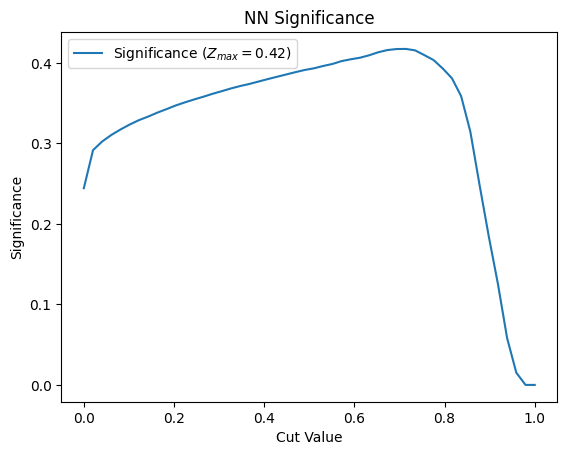

In [22]:
int_pred_test_sig = [weights_test[(y_test == 1) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]
int_pred_test_bkg = [weights_test[(y_test == 0) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]
vamsasimov = [amsasimov(sumsig, sumbkg) for (sumsig, sumbkg) in zip(int_pred_test_sig, int_pred_test_bkg)]
Z = max(vamsasimov)

plt.plot(np.linspace(0, 1, num=50), vamsasimov, label=f'Significance ($Z_{{max}} = {np.round(Z, decimals=2)}$)')
plt.title("NN Significance")
plt.xlabel("Cut Value")
plt.ylabel("Significance")
plt.legend()
plt.show()

## What does overtraining look like?

Recipe:
1. Add More layers
2. Add more nodes per layer
3. Train on less data
4. Train for more iterations

In [23]:
# Crazy Example
N = len(X_train)
n = int(N / 10000)
print("Using", n, "/", N, "events")

X_small = X_train[:n]
y_small = y_train[:n]
weights_small = weights_train[:n]

Using 28 / 288678 events


In [24]:
ot_model = tf.keras.models.Sequential(
    [
        tf.keras.Input((X_small.shape[1],)),  # input layer
        tf.keras.layers.Dense(512, activation='relu'),  # 1st hiddden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
ot_model.compile(loss="binary_crossentropy", optimizer="adam", weighted_metrics=[AUC(name="auc")])

the_overfit = ot_model.fit(
    X_small,
    y_small.values,
    sample_weight=weights_small,
    epochs=25,
    batch_size=128,
    validation_data=(X_val, y_val, weights_val),
)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - auc: 0.2964 - loss: 1.5064 - val_auc: 0.6773 - val_loss: 1.3332
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - auc: 0.9405 - loss: 1.3395 - val_auc: 0.6852 - val_loss: 1.2970
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - auc: 0.9405 - loss: 1.2139 - val_auc: 0.6862 - val_loss: 1.2743
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - auc: 0.9393 - loss: 1.0974 - val_auc: 0.6858 - val_loss: 1.2676
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - auc: 0.9383 - loss: 0.9789 - val_auc: 0.6850 - val_loss: 1.2819
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - auc: 0.9612 - loss: 0.8625 - val_auc: 0.6844 - val_loss: 1.3211
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - auc: 0.9603 - loss: 0.7509 - val_auc: 0.6840 - val_loss: 1.3879
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - auc: 0.9681 - loss: 0.6474 - val_auc: 0.6837 - val_loss: 1.4822
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - auc: 0.9757 - loss: 0.5524 - val_auc: 0.6836 - 

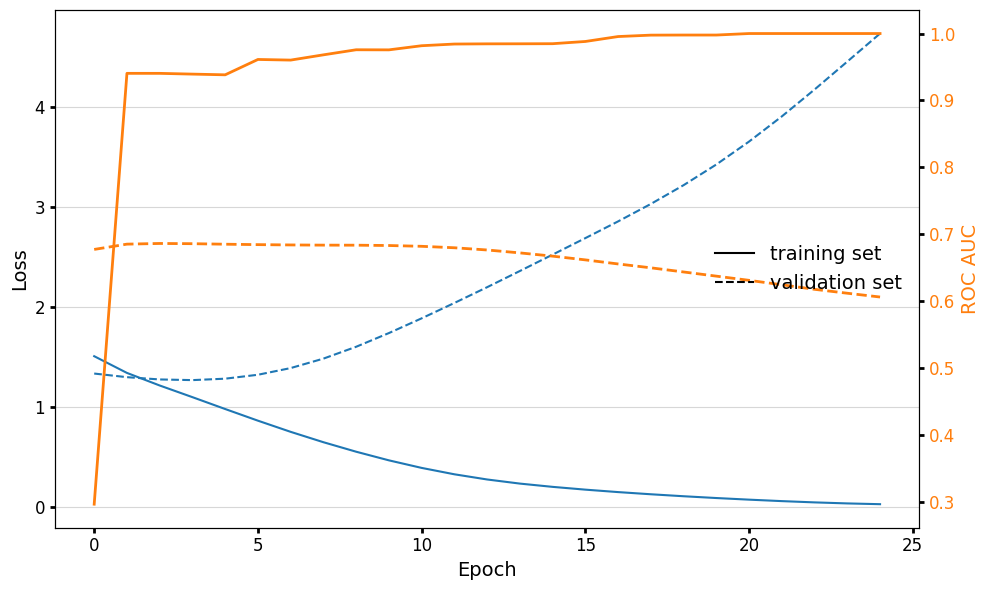

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(the_overfit.history['loss'], color="tab:blue")
ax.plot(the_overfit.history['val_loss'], color="tab:blue", ls="--")
ax.set_xlabel("Epoch", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.tick_params(width=2, grid_alpha=0.5, labelsize=12)
ax.grid(True, axis='y')

ax2 = ax.twinx()
ax2.set_ylabel("ROC AUC", color='tab:orange', fontsize=14)
ax2.tick_params(width=2, grid_alpha=0.5, labelsize=12, axis='y', labelcolor='tab:orange')
ax2.plot(the_overfit.history['auc'], color='tab:orange', lw=2)
ax2.plot(the_overfit.history['val_auc'], color='tab:orange', ls='--', lw=2)
# ax2.set_ylim([0, 1])

ax2.plot([], [], color="black", label="training set")
ax2.plot([], [], color="black", ls='--', label="validation set")
ax2.legend(fontsize=14, frameon=False, loc="right")
fig.tight_layout()

In [26]:
ot_y_pred_test = ot_model.predict(X_test).flatten()
ot_y_pred_train = ot_model.predict(X_small).flatten()

4511/4511 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


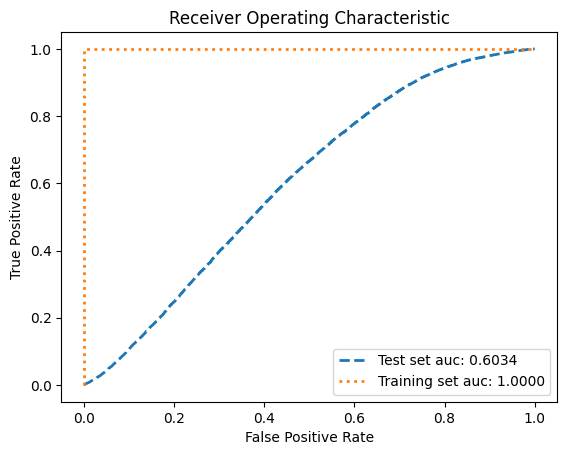

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=ot_y_pred_test, sample_weight=weights_test)
fpr_train, tpr_train, _ = roc_curve(y_true=y_small, y_score=ot_y_pred_train, sample_weight=weights_small)
auc_test = roc_auc_score(y_true=y_test, y_score=ot_y_pred_test, sample_weight=weights_test)
auc_train = roc_auc_score(y_true=y_small.values, y_score=ot_y_pred_train, sample_weight=weights_small)
plt.plot(fpr_test, tpr_test, color='tab:blue', lw=2, ls="--", label=f"Test set auc: {auc_test:.4f}")
plt.plot(fpr_train, tpr_train, color='tab:orange', lw=2, ls=":", label=f"Training set auc: {auc_train:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Exercises

### Can we try to improve the neural network performance?

Hints:
- Adjust learning rate
- Adjust the number of neurons, and layers
- Increase epochs
- Enable early stopping (and increase max epochs)
- Adjust batch size
- Change activations: [relu, leakyrelu, selu, tanh]
- Try different optimizers (e.g. SGD)
- Dynamic learning rate: e.g. tfa.optimizers.RectifiedAdam as the optimizer, tf.keras.callbacks.ReduceLROnPlateau as a callback
- Use a more complicated structure? e.g. RNN, deep sets, GNN, etc
- More... google!

### What happens when we add more features or engineer aditional Features?

Try it yourself!

### What happens when we don't standardize our inputs?

Try it yourself!

What about a different prescaling (using [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for example?)

### What happens when we don't use balanced weights for signal and background?

Use the raw MC weights and retrain the model.

Does the "natural" weight always give the best performance?